In [ ]:
# Importing modules
import pandas as pd
# Read data into papers
papers = pd.read_csv('/content/final.csv')
# Print head
papers.head()

,Unnamed: 0,title,description,recentChanges
0,0,Eye Filter (Blue light filter),"This app draws a translucent mask over screen,...",Minor improvement.\r\nAllow remove ads by IAP.
1,1,Drizly: Fast alcohol delivery,Get the door. It's the liquor store.™\r\n\r\nL...,Fixes bug with facebook login and creating a n...
2,2,Card Maker for PKM,PKM Card Maker is where you can make your own ...,- 🛠 Improvement and bug fix !!
3,3,Progression - Workout Tracker,"Workout tracking, made simple and beautiful\r\...",NaN
4,4,My Finances,My Finances is a perfect tool for expense cont...,Fix for fullscreen Ads


In [ ]:
# Load the regular expression library
import re
# Remove punctuation
papers['recentChanges']=papers['recentChanges'].apply(str)
papers['paper_text_processed'] = papers['recentChanges'].map(lambda x: re.sub('[,\.!?]', '', x))
papers['paper_text_processed'] = papers['recentChanges'].map(lambda x: re.sub('[www]', '', x))
papers['paper_text_processed'] = papers['recentChanges'].map(lambda x: re.sub('[com]', '', x))

# Convert the titles to lowercase
papers['paper_text_processed'] = papers['paper_text_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
papers['paper_text_processed'].head()

0              minr iprveent.\r\nallw reve ads by iap.
1    fixes bug with faebk lgin and reating a new dr...
2                         - 🛠 iprveent and bug fix !! 
3                                                  nan
4                                 fix fr fullsreen ads
Name: paper_text_processed, dtype: object

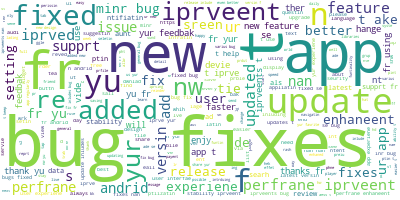

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(papers['paper_text_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [ ]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
             if word not in stop_words] for doc in texts]
data = papers.paper_text_processed.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['minr', 'iprveent', 'allw', 'reve', 'ads', 'iap']


In [ ]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]


In [ ]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.026*"yu" + 0.019*"fr" + 0.018*"yur" + 0.016*"fixed" + 0.014*"app" + '
  '0.013*"new" + 0.010*"bug" + 0.010*"andrid" + 0.009*"de" + 0.009*"added"'),
 (1,
  '0.050*"fixes" + 0.043*"bug" + 0.032*"yu" + 0.029*"iprveents" + 0.025*"fr" + '
  '0.018*"app" + 0.016*"yur" + 0.016*"new" + 0.013*"perfrane" + 0.012*"minr"'),
 (2,
  '0.038*"perfrane" + 0.025*"iprveents" + 0.024*"fixes" + 0.023*"fr" + '
  '0.019*"bug" + 0.019*"bugs" + 0.018*"app" + 0.017*"fixed" + 0.015*"iprved" + '
  '0.013*"yu"'),
 (3,
  '0.033*"added" + 0.020*"new" + 0.017*"fr" + 0.013*"fixed" + 0.012*"fixes" + '
  '0.012*"bug" + 0.011*"bugs" + 0.009*"andrid" + 0.008*"de" + 0.008*"supprt"'),
 (4,
  '0.039*"fr" + 0.020*"new" + 0.019*"app" + 0.016*"user" + 0.016*"yu" + '
  '0.015*"yur" + 0.015*"bug" + 0.014*"added" + 0.014*"fixed" + 0.014*"fixes"'),
 (5,
  '0.028*"fr" + 0.019*"iprved" + 0.014*"app" + 0.013*"fixes" + 0.013*"yu" + '
  '0.011*"nw" + 0.011*"de" + 0.010*"axi" + 0.010*"bug" + 0.009*"new"'),
 (6,
  '0.041*"nan" +

In [ ]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.48434103439707554


**Finding Optimal Number of Topics for highest coherence value**

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model =  lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics,
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words, start=2, limit=40, step=6)

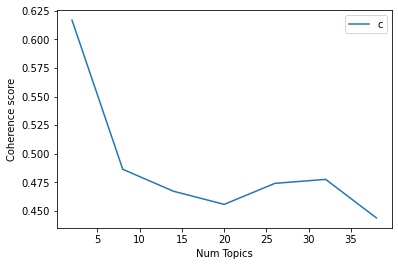

In [ ]:
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.6168
Num Topics = 8  has Coherence Value of 0.4864
Num Topics = 14  has Coherence Value of 0.4672
Num Topics = 20  has Coherence Value of 0.4557
Num Topics = 26  has Coherence Value of 0.4741
Num Topics = 32  has Coherence Value of 0.4776
Num Topics = 38  has Coherence Value of 0.4438


In [ ]:
#Finding index of max coherence value then using it to get optimal num_topics
index= coherence_values.index(max(coherence_values))
num_topics= x[index]
print(num_topics)

2


In [ ]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           )

In [ ]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.6117714042174092


In [ ]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 20.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=dfbbe8dd61958819289b2c37ff386498f6889a5913f2f3c5a6509f1e993b0332
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


**Intertopic Distance (Visualisation)**

In [ ]:
import pyLDAvis.gensim_models
import pickle
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.156729  0.0       1        1  59.537717
1     -0.156729  0.0       2        1  40.462283, topic_info=          Term        Freq       Total Category  logprob  loglift
7          bug  669.000000  669.000000  Default  30.0000  30.0000
11       fixes  663.000000  663.000000  Default  29.0000  29.0000
160         yu  584.000000  584.000000  Default  28.0000  28.0000
83   iprveents  449.000000  449.000000  Default  27.0000  27.0000
63       added  268.000000  268.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
252        mre   37.929278   56.724847   Topic2  -5.8293   0.5023
66     feature   44.396275   87.288959   Topic2  -5.6719   0.2287
319       play   30.910385   40.312572   Topic2  -6.0339   0.6392
16          se   45.247837  215.716818   Topic2  -5.6529  -0.6570
30         app   39.731323  519.914734   Topic2  -5.7829  -1.6667

[128 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
189       1  0.148352     add
189       2  0.858322     add
63        1  0.037232   added
63        2  0.960588   added
74        1  0.998144     ade
...     ...       ...     ...
272       2  0.962773  widget
160       1  0.980424      yu
160       2  0.020532      yu
161       1  0.946036     yur
161       2  0.053641     yur

[162 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.insert (1, "App_name", papers['title'])
del df_dominant_topic['Document_No']
# Show
df_dominant_topic.head(10)

,App_name,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,Eye Filter (Blue light filter),1.0,0.6385,"fr, added, fixed, new, de, fix, andrid, nw, ip...",minr iprveent.\r\nallw reve ads by iap.
1,Drizly: Fast alcohol delivery,0.0,0.9644,"bug, fixes, yu, fr, app, iprveents, yur, perfr...",fixes bug with faebk lgin and reating a new dr...
2,Card Maker for PKM,0.0,0.6940,"bug, fixes, yu, fr, app, iprveents, yur, perfr...",- 🛠 iprveent and bug fix !!
3,Progression - Workout Tracker,0.0,0.7499,"bug, fixes, yu, fr, app, iprveents, yur, perfr...",nan
4,My Finances,1.0,0.8818,"fr, added, fixed, new, de, fix, andrid, nw, ip...",fix fr fullsreen ads
5,0-200 Situps Abs Trainer,1.0,0.5508,"fr, added, fixed, new, de, fix, andrid, nw, ip...","suer is in full effet, let's get that beah bdy!"
6,WDSU Parade Tracker,0.0,0.7585,"bug, fixes, yu, fr, app, iprveents, yur, perfr...",as parades begin t return t new orleans the wd...
7,Animal Planet GO,0.0,0.8219,"bug, fixes, yu, fr, app, iprveents, yur, perfr...",• nw streaing ntent fr up t 14 netwrks fr the ...
8,Fuelmeter: Fuel consumption,0.0,0.7499,"bug, fixes, yu, fr, app, iprveents, yur, perfr...",nan
9,Wishbone - Compare Anything,0.0,0.8333,"bug, fixes, yu, fr, app, iprveents, yur, perfr...",bug fixes


In [ ]:
from google.colab import files
df_dominant_topic.to_csv('Recent_Changes_analysis.csv', encoding = 'utf-8-sig')
files.download('Recent_Changes_analysis.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>